In [564]:
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Carregamento e tratamento da base

In [565]:
pathsAndLinksTemp = pd.read_excel ('PathsAndLinksExcel.xlsx')

pathsAndLinksTemp.to_csv("PathsAndLinks.csv", index = None, header = True)

pathsAndLinksDf = pd.DataFrame(pd.read_csv("PathsAndLinks.csv"))

pathsAndLinksDf.head()

,OrigZoneNo,DestZoneNo,Index,Path_Volume,Path_UnloadedTime,Path_UnloadedSpeed,Path_LoadedTime,Path_LoadedSpeed,Links_Count,Links_MinCarCapacity,...,Links_MinUnloadedTime,Links_MaxUnloadedTime,Links_AvgUnloadedTime,Links_SumUnloadedTime,Links_MinLoadedTime,Links_MaxLoadedTime,Links_AvgLoadedTime,Links_SumLoadedTime,Links_ToNodeNo,Links_FromNodeNo
0,10,20,1,19208.000,2min 23s,36km/h,3min 10s,27km/h,3,500,...,8s,20s,13s,40s,8s,22s,14s,43s,"2642,153,3111","3412,2642,153"
1,10,20,2,1064.000,2min 14s,38km/h,3min 10s,27km/h,3,500,...,7s,39s,22s,1min 6s,7s,43s,24s,1min 12s,"2645,153,3111","3064,2645,153"
2,10,30,1,36624.000,2min,38km/h,2min 22s,32km/h,3,500,...,11s,30s,21s,1min 2s,13s,35s,23s,1min 10s,"138,3351,162","137,138,3351"
3,10,40,1,18483.000,3min 5s,29km/h,3min 32s,26km/h,7,500,...,6s,22s,14s,1min 41s,6s,24s,15s,1min 45s,"10000658,3081,2649,130,139,140,3389","3064,10000658,3081,2649,130,139,140"
4,10,40,2,0.481,2min 59s,32km/h,3min 32s,27km/h,5,500,...,6s,45s,23s,1min 56s,6s,47s,27s,2min 14s,"3404,130,139,140,3389","3077,3404,130,139,140"


In [566]:
for x in pathsAndLinksDf:
    if pathsAndLinksDf[x].dtypes == object:
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('km/h', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('km', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('min', '.'))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace(' ', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('h', ''))
        pathsAndLinksDf[x] = pathsAndLinksDf[x].apply(lambda x: x.replace('s', ''))


singleLinks = pathsAndLinksDf[['Links_ToNodeNo', 'Links_FromNodeNo']]

pathsAndLinksDf = pathsAndLinksDf.drop(['Links_ToNodeNo', 'Links_FromNodeNo', 'OrigZoneNo', 'Index', 'Path_Volume'], axis=1)

pathsAndLinksDf = pathsAndLinksDf.apply(pd.to_numeric)

Legenda:

DestZoneNo -> Numero da zona de destino [int64]

(Removida) Path_Volume -> Cálculo de volume de veículos considerando o path (caminho inteiro) [float64]

Path_UnloadedTime -> Tempo de locomoção no path considerando as vias sem transito (calculo mais simplificado considerando a velocidade média da via e a distância) [float64]

Path_UnloadedSpeed ->  Velocidade de locomoção no path considerando as vias sem transito [int64]

Path_LoadedTime -> Tempo de locomoção no path considerando as vias com transito (vem ao rodar a simulação) [float64]

Path_LoadedSpeed -> Velocidade de locomoção no path considerando as vias com transito [int64]

Links_Count -> Quantidade de links que compõe o path [int64]

Links_(Min, Max, Avg, Sum)CarCapacity -> Colunas referente à capacidade de carros nos links/vias [int64]

Links_(Min, Max, Avg, Sum)Length -> Colunas referente ao tamanho das vias [float64]

Links_(Min, Max, Avg, Sum)OfCars -> Colunas referente à quantidade de carros nos links/vias [int64]

Links_(Min, Max, Avg)LoadedSpeed -> Colunas referente à velocidade nas vias/links considerando o transito [int64]

Links_(Min, Max, Avg, Sum)UnloadedTime -> Colunas referente ao tempo de locomoção nas vias/links não considerando o transito [int64, float64]

Links_(Min, Max, Avg, Sum)LoadedTime -> Colunas referente ao tempo de locomoção nas vias/links considerando o transito [int64, float64]

Colunas excluídas:
OrigZoneNo -> Número de origem (sempre 10)  [int64]

Index -> Repetitivo e considera os pares de origem destino, não vi utilidade (a confirmar) [int64]

Links_FromNodeNo -> Lista de nós de partida (essa coluna e a abaixo podem ter alguma utilidade, mas não enxerguei ainda) [object]

Links_ToNodeNo -> Lista de nós de Chegada [object]


In [567]:
pathsAndLinksDf

,DestZoneNo,Path_UnloadedTime,Path_UnloadedSpeed,Path_LoadedTime,Path_LoadedSpeed,Links_Count,Links_MinCarCapacity,Links_MaxCarCapacity,Links_AvgCarCapacity,Links_SumCarCapacity,...,Links_MaxLoadedSpeed,Links_AvgLoadedSpeed,Links_MinUnloadedTime,Links_MaxUnloadedTime,Links_AvgUnloadedTime,Links_SumUnloadedTime,Links_MinLoadedTime,Links_MaxLoadedTime,Links_AvgLoadedTime,Links_SumLoadedTime
0,20,2.23,36,3.10,27,3,500,800,600,1800,...,29,28,8,20.00,13,40.00,8,22.00,14,43.00
1,20,2.14,38,3.10,27,3,500,800,600,1800,...,29,28,7,39.00,22,1.60,7,43.00,24,1.12
2,30,2.00,38,2.22,32,3,500,800,600,1800,...,29,26,11,30.00,21,1.20,13,35.00,23,1.10
3,40,3.50,29,3.32,26,7,500,2000,971,6800,...,30,29,6,22.00,14,1.41,6,24.00,15,1.45
4,40,2.59,32,3.32,27,5,500,2000,860,4300,...,29,27,6,45.00,23,1.56,6,47.00,27,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,580,11.40,51,15.18,39,34,500,4200,2288,77800,...,80,41,1,1.18,17,9.29,2,1.19,22,12.34
135,590,5.28,34,9.54,19,17,500,4200,1918,32600,...,38,26,0,1.19,14,4.30,1,1.19,22,6.11
136,590,6.40,34,9.53,21,20,500,4200,1555,31100,...,38,24,0,1.19,13,4.21,1,1.19,21,6.54
137,600,5.45,45,10.33,25,22,500,4200,2609,57400,...,75,37,1,38.00,12,4.24,2,51.00,19,6.54


<AxesSubplot:>

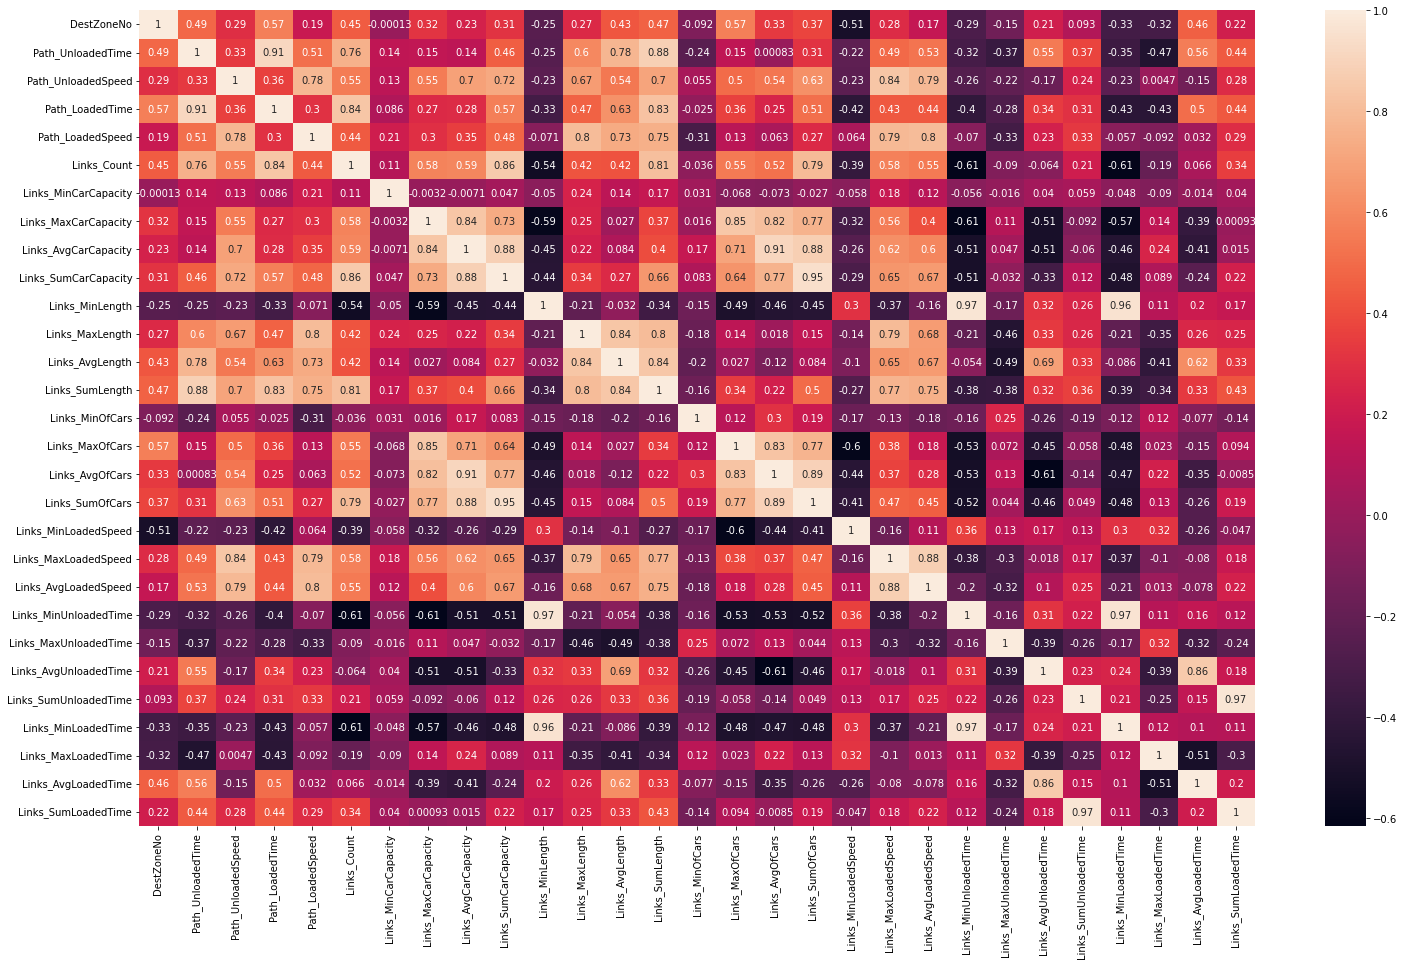

In [568]:
fig_dims = (25,15)
fig, ax = plt.subplots(figsize=fig_dims)

corr = pathsAndLinksDf.corr()
sns.heatmap(corr, annot=True)

In [569]:
def print_results(predictions, y_testy):
    errors = abs(predictions - y_testy)
    out_mape = round(np.mean(errors), 2)
    print('    Mean Absolute Error:', out_mape, 'degrees.')
    mape = 100 * (errors / y_testy)
    accuracy = 100 - np.mean(mape)
    accuracy = round(accuracy, 2)
    print('    Accuracy:', accuracy, '%.')
    return accuracy, out_mape


In [570]:
def save_accuracy(predictions, y_testy):
    errors = abs(predictions - y_testy)
    out_mape = round(np.mean(errors), 2)
    mape = 100 * (errors / y_testy)
    accuracy = 100 - np.mean(mape)
    accuracy = round(accuracy, 2)
    return accuracy


# Dados simulados completos

## Y = Links_SumOfCars

In [571]:
df_SumOfCars = pathsAndLinksDf

In [572]:
y = np.array(df_SumOfCars['Links_SumOfCars'])
X = df_SumOfCars.drop('Links_SumOfCars', axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [573]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree Regressor Pipeline (Links_SumOfCars)

In [574]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [575]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,600,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [576]:
%%time
search.fit(X_train, y_train)

CPU times: total: 375 ms
Wall time: 369 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160, 210, 260,
                                                  310, 360, 410, 460, 510,
                                                  560],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [577]:
search.best_params_

{'dec_tree__criterion': 'squared_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'auto'}

In [578]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(max_depth=10, max_features='auto',
                                       random_state=42))])

In [579]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.5345606000033749    MSE: 54962187.166666664


In [580]:
print_results(y_pred, y_test)

    Mean Absolute Error: 5726.21 degrees.
    Accuracy: 85.47 %.


(85.47, 5726.21)

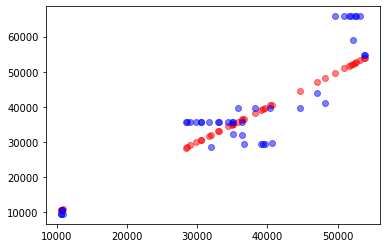

In [581]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

### Random Forest Pipeline (Links_SumOfCars)

In [582]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [583]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(400,420, 2)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [584]:
%%time
search.fit(X_train, y_train)

CPU times: total: 59.2 s
Wall time: 1min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [400, 402, 404, 406, 408, 410,
                                                   412, 414, 416, 418]}],
             return_train_score=True)

In [585]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 400}

In [586]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=400,
                                       random_state=37))])

In [587]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.7889351002710254    MSE: 7007319.012464471


In [588]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2024.45 degrees.
    Accuracy: 94.34 %.


(94.34, 2024.45)

In [589]:
forrest_model_reg = RandomForestRegressor(n_estimators = 411,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 2062.54 degrees.
    Accuracy: 94.29 %.


(94.29, 2062.54)

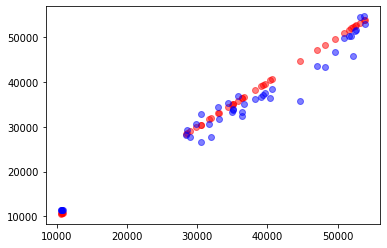

In [590]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [591]:
rf_SumOfCars = save_accuracy(forrest_predictions, y_test)

## Y = Path_LoadedSpeed

In [592]:
df_LoadedSpeed = pathsAndLinksDf

In [593]:
y = np.array(df_LoadedSpeed['Path_LoadedSpeed'])
X = df_LoadedSpeed.drop('Path_LoadedSpeed', axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [594]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree Regressor Pipeline (Path_LoadedSpeed)

In [595]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [596]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,600,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [597]:
%%time
search.fit(X_train, y_train)

CPU times: total: 359 ms
Wall time: 383 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160, 210, 260,
                                                  310, 360, 410, 460, 510,
                                                  560],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [598]:
search.best_params_

{'dec_tree__criterion': 'absolute_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'log2'}

In [599]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                                       max_features='log2', random_state=42))])

In [600]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: -0.3153284671532848    MSE: 69.85714285714286


In [601]:
print_results(y_pred, y_test)

    Mean Absolute Error: 5.67 degrees.
    Accuracy: 80.56 %.


(80.56, 5.67)

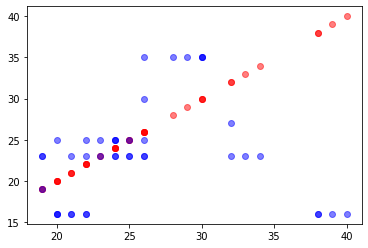

In [602]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

### Random Forest Pipeline (Path_LoadedTime)

In [603]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [604]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(180,200, 2)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [605]:
%%time
search.fit(X_train, y_train)

CPU times: total: 29 s
Wall time: 29.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [180, 182, 184, 186, 188, 190,
                                                   192, 194, 196, 198]}],
             return_train_score=True)

In [606]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'log2',
 'forest__n_estimators': 186}

In [607]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='log2', n_estimators=186,
                                       random_state=37))])

In [608]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.5891827007299271    MSE: 15.26361291423726


In [609]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.01 degrees.
    Accuracy: 88.82 %.


(88.82, 3.01)

In [610]:
forrest_model_reg = RandomForestRegressor(n_estimators = 186,criterion='absolute_error',max_features= 'log2', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 2.95 degrees.
    Accuracy: 89.16 %.


(89.16, 2.95)

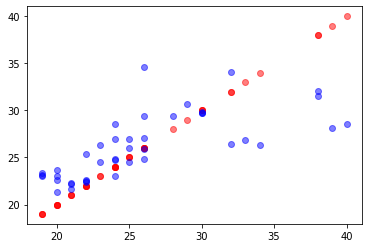

In [611]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [612]:
rf_LoadedSpeed = save_accuracy(forrest_predictions, y_test)

## Y = Path_LoadedTime

In [613]:
df_LoadedTime = pathsAndLinksDf

In [614]:
y = np.array(df_LoadedTime['Path_LoadedTime'])
X = df_LoadedTime.drop('Path_LoadedTime', axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [615]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree Regressor Pipeline (Path_LoadedTime)

In [616]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [617]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,600,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [618]:
%%time
search.fit(X_train, y_train)

CPU times: total: 375 ms
Wall time: 370 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160, 210, 260,
                                                  310, 360, 410, 460, 510,
                                                  560],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [619]:
search.best_params_

{'dec_tree__criterion': 'squared_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'sqrt'}

In [620]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(max_depth=10, max_features='sqrt',
                                       random_state=42))])

In [621]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.1251743588977957    MSE: 13.288416666666663


In [622]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.49 degrees.
    Accuracy: 85.85 %.


(85.85, 2.49)

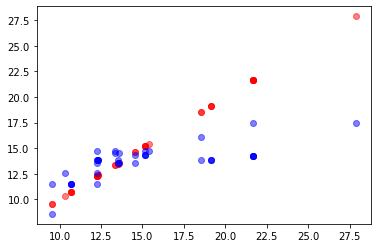

In [623]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

### Random Forest Pipeline (Path_LoadedTime)

In [624]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [625]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(90,110, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [626]:
%%time
search.fit(X_train, y_train)

CPU times: total: 29.3 s
Wall time: 29.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [90, 91, 92, 93, 94, 95, 96,
                                                   97, 98, 99, 100, 101, 102,
                                                   103, 104, 105, 106, 107, 108,
                                                   109]}],
             return_train_score=True)

In [627]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 92}

In [628]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=92,
                                       random_state=37))])

In [629]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.46879293805140554    MSE: 11.080123990120613


In [630]:
print_results(y_pred, y_test)

    Mean Absolute Error: 2.15 degrees.
    Accuracy: 88.39 %.


(88.39, 2.15)

In [631]:
forrest_model_reg = RandomForestRegressor(n_estimators = 92,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 2.15 degrees.
    Accuracy: 88.39 %.


(88.39, 2.15)

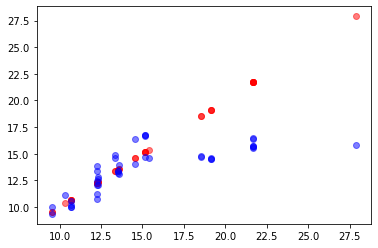

In [632]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [633]:
rf_LoadedTime = save_accuracy(forrest_predictions, y_test)

# Esparsidade de dados

## Remoção de colunas inteiras

In [634]:
df_SparseColumns = pathsAndLinksDf

In [635]:
df_SparseColumns = df_SparseColumns.drop(['DestZoneNo', 'Path_UnloadedTime', 'Path_UnloadedSpeed', 'Links_Count', 'Links_MaxOfCars', 'Links_AvgOfCars', 'Links_MinLoadedSpeed', 'Links_MaxLoadedSpeed', 'Links_AvgLoadedSpeed', 'Links_MinUnloadedTime', 'Links_MaxUnloadedTime', 'Links_SumUnloadedTime', 'Links_MinLoadedTime', 'Links_MaxLoadedTime', 'Links_AvgLoadedTime', 'Links_SumLoadedTime'], axis=1)

In [636]:
df_SparseColumns

,Path_LoadedTime,Path_LoadedSpeed,Links_MinCarCapacity,Links_MaxCarCapacity,Links_AvgCarCapacity,Links_SumCarCapacity,Links_MinLength,Links_MaxLength,Links_AvgLength,Links_SumLength,Links_MinOfCars,Links_SumOfCars,Links_AvgUnloadedTime
0,3.10,27,500,800,600,1800,0.066,0.167,0.111,0.332,179,702,13
1,3.10,27,500,800,600,1800,0.055,0.327,0.183,0.549,221,713,22
2,2.22,32,500,800,600,1800,0.090,0.252,0.171,0.513,271,856,21
3,3.32,26,500,2000,971,6800,0.051,0.183,0.120,0.840,76,2137,14
4,3.32,27,500,2000,860,4300,0.051,0.379,0.193,0.967,143,1718,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,15.18,39,500,4200,2288,77800,0.016,1.062,0.263,8.927,59,52458,17
135,9.54,19,500,4200,1918,32600,0.007,0.658,0.159,2.704,6,31988,14
136,9.53,21,500,4200,1555,31100,0.007,0.658,0.140,2.807,6,30513,13
137,10.33,25,500,4200,2609,57400,0.019,0.493,0.171,3.759,6,47133,12


### Y = Links_SumOfCars (colunas removidas)

In [637]:
df_SparseColumn_SumOfCars = df_SparseColumns

In [638]:
y = np.array(df_SparseColumn_SumOfCars['Links_SumOfCars'])
X = df_SparseColumn_SumOfCars.drop('Links_SumOfCars', axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [639]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Decision Tree Regressor Pipeline (Links_SumOfCars com colunas removidas)

In [640]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [641]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,100,15)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [642]:
%%time
search.fit(X_train, y_train)

CPU times: total: 156 ms
Wall time: 167 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 25, 40, 55, 70, 85],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [643]:
search.best_params_

{'dec_tree__criterion': 'squared_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'auto'}

In [644]:
search.best_estimator_


Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(max_depth=10, max_features='auto',
                                       random_state=42))])

In [645]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.3021334564816728    MSE: 121861695.04761904


In [646]:
print_results(y_pred, y_test)

    Mean Absolute Error: 9601.67 degrees.
    Accuracy: 74.41 %.


(74.41, 9601.67)

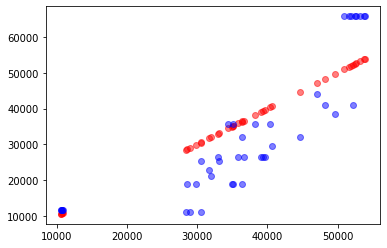

In [647]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

#### Random Forest Pipeline (Links_SumOfCars com colunas removidas)

In [648]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [649]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(1, 20, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [650]:
%%time
search.fit(X_train, y_train)

CPU times: total: 3.17 s
Wall time: 3.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19]}],
             return_train_score=True)

In [651]:
search.best_params_

{'forest__criterion': 'absolute_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 13}

In [652]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=13,
                                       random_state=37))])

In [653]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.591809809504228    MSE: 16923573.772189353


In [654]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3621.19 degrees.
    Accuracy: 89.2 %.


(89.2, 3621.19)

In [655]:
forrest_model_reg = RandomForestRegressor(n_estimators = 13,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 3621.19 degrees.
    Accuracy: 89.2 %.


(89.2, 3621.19)

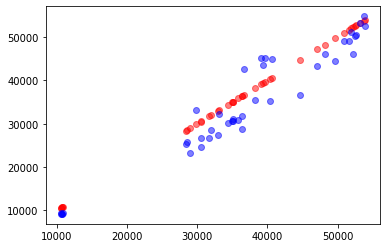

In [656]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [657]:
rf_SumOfCars_LessColumn = save_accuracy(forrest_predictions, y_test)

### Y = Path_LoadedSpeed (colunas removidas)

In [658]:
df_SparseColumn_LoadedSpeed = df_SparseColumns

In [659]:
y = np.array(df_SparseColumn_LoadedSpeed ['Path_LoadedSpeed'])
X = df_SparseColumn_LoadedSpeed .drop('Path_LoadedSpeed', axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [660]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Decision Tree Regressor Pipeline (Path_LoadedSpeed colunas removidas)

In [661]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [662]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,200,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [663]:
%%time
search.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 111 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [664]:
search.best_params_

{'dec_tree__criterion': 'absolute_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'sqrt'}

In [665]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                                       max_features='sqrt', random_state=42))])

In [666]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.36715328467153285    MSE: 23.69047619047619


In [667]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.74 degrees.
    Accuracy: 85.89 %.


(85.89, 3.74)

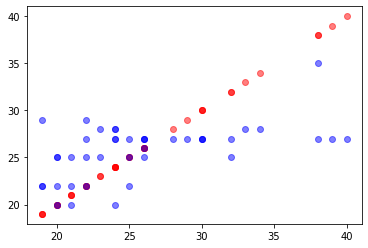

In [668]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

#### Random Forest Pipeline (Path_LoadedSpeed colunas removidas)

In [669]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [670]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(10,200, 20)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [671]:
%%time
search.fit(X_train, y_train)

CPU times: total: 14.5 s
Wall time: 14.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [10, 30, 50, 70, 90, 110, 130,
                                                   150, 170, 190]}],
             return_train_score=True)

In [672]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 30}

In [673]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=30,
                                       random_state=37))])

In [674]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.46240824817518245    MSE: 19.601798941798943


In [675]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.55 degrees.
    Accuracy: 86.67 %.


(86.67, 3.55)

In [676]:
forrest_model_reg = RandomForestRegressor(n_estimators = 30,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 3.49 degrees.
    Accuracy: 86.83 %.


(86.83, 3.49)

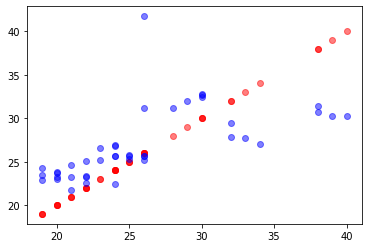

In [677]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [678]:
rf_LoadedSpeed_LessColumn = save_accuracy(forrest_predictions, y_test)

### Y = Path_LoadedTime (colunas removidas)

In [679]:
df_SparseColumn_LoadedTime = df_SparseColumns

In [680]:
y = np.array(df_SparseColumn_LoadedTime ['Path_LoadedSpeed'])
X = df_SparseColumn_LoadedTime .drop('Path_LoadedSpeed', axis = 1)
x_names = list(X.columns)
X = np.array(X)

In [681]:
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Decision Tree Regressor Pipeline (Path_LoadedSpeed removidas)

In [682]:
DT_regressor = DecisionTreeRegressor(random_state=42)
DT_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [683]:
search_paramns = [
    dict(dec_tree__criterion=["squared_error", "friedman_mse", "absolute_error", "poisson"],
         dec_tree__max_depth=list(range(10,200,50)),
            dec_tree__max_features=["auto","sqrt", "log2"])
]

pipe = Pipeline([
    ('dec_tree', DT_regressor)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=tscv,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [684]:
%%time
search.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 112 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('dec_tree',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid=[{'dec_tree__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                          'dec_tree__max_depth': [10, 60, 110, 160],
                          'dec_tree__max_features': ['auto', 'sqrt', 'log2']}],
             return_train_score=True)

In [685]:
search.best_params_

{'dec_tree__criterion': 'absolute_error',
 'dec_tree__max_depth': 10,
 'dec_tree__max_features': 'sqrt'}

In [686]:
search.best_estimator_

Pipeline(steps=[('dec_tree',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                                       max_features='sqrt', random_state=42))])

In [687]:
y_pred = search.predict(X_test)

r2_score = DT_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.36715328467153285    MSE: 23.69047619047619


In [688]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.74 degrees.
    Accuracy: 85.89 %.


(85.89, 3.74)

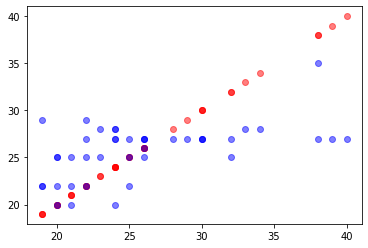

In [689]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)

#### Random Forest Pipeline (Path_LoadedSpeed colunas removidas)

In [690]:
forrest_model_reg = RandomForestRegressor(random_state=37)
forrest_model_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=37)

In [691]:
search_paramns = [{
    'forest__criterion': ["squared_error", "absolute_error"],
    'forest__n_estimators': list(range(10,30, 1)), 
    'forest__max_features': ["sqrt", "log2"]
}]

pipe = Pipeline([
    ('forest', forrest_model_reg)
])

search = GridSearchCV(estimator=pipe,
                     param_grid=search_paramns,
                     cv=5,
                     return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [692]:
%%time
search.fit(X_train, y_train)

CPU times: total: 6.11 s
Wall time: 6.19 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=37))]),
             param_grid=[{'forest__criterion': ['squared_error',
                                                'absolute_error'],
                          'forest__max_features': ['sqrt', 'log2'],
                          'forest__n_estimators': [10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29]}],
             return_train_score=True)

In [693]:
search.best_params_

{'forest__criterion': 'squared_error',
 'forest__max_features': 'sqrt',
 'forest__n_estimators': 23}

In [694]:
search.best_estimator_

Pipeline(steps=[('forest',
                 RandomForestRegressor(max_features='sqrt', n_estimators=23,
                                       random_state=37))])

In [695]:
y_pred = search.predict(X_test)

r2_score = forrest_model_reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'r2: {r2_score}    MSE: {mse}')

r2: 0.46240824817518245    MSE: 19.343235214690793


In [696]:
print_results(y_pred, y_test)

    Mean Absolute Error: 3.56 degrees.
    Accuracy: 86.54 %.


(86.54, 3.56)

In [697]:
forrest_model_reg = RandomForestRegressor(n_estimators = 23,criterion='absolute_error',max_features= 'sqrt', random_state=37)
forrest_model_reg.fit(X_train, y_train)

forrest_predictions = forrest_model_reg.predict(X_test)
print_results(forrest_predictions, y_test)

    Mean Absolute Error: 3.5 degrees.
    Accuracy: 86.68 %.


(86.68, 3.5)

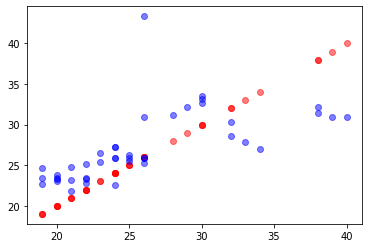

In [698]:
plt.scatter(y_test, y_test, c='red', alpha=0.5)
plt.scatter(y_test, forrest_predictions, c='blue', alpha=0.5)

In [699]:
rf_LoadedTime_LessColumn = save_accuracy(forrest_predictions, y_test)

## Resultados

In [705]:
print("Acurácia da Random Forest na predição do número de veículos num determinado caminho:")
print("Dados simulados completos (30 colunas de dados): ", rf_SumOfCars, "%")
print("Colunas removidas (13 colunas de dados): ", rf_SumOfCars_LessColumn, "%")
print("---------------------------------------------------------------------------------------------------------")
print("Acurácia da Random Forest na predição da velocidade de locomoção média dos veículos num determinado caminho:")
print("Dados simulados completos (30 colunas de dados): ", rf_LoadedSpeed, "%")
print("Colunas removidas (13 colunas de dados): ", rf_LoadedSpeed_LessColumn, "%")
print("---------------------------------------------------------------------------------------------------------")
print("Acurácia da Random Forest do tempo de locomoção média dos veículos num determinado caminho:")
print("Dados simulados completos (30 colunas de dados): ", rf_LoadedTime, "%")
print("Colunas removidas (13 colunas de dados): ", rf_LoadedTime_LessColumn, "%")

Acurácia da Random Forest na predição do número de veículos num determinado caminho:
Dados simulados completos (30 colunas de dados):  94.29 %
Colunas removidas (13 colunas de dados):  89.2 %
---------------------------------------------------------------------------------------------------------
Acurácia da Random Forest na predição da velocidade de locomoção média dos veículos num determinado caminho:
Dados simulados completos (30 colunas de dados):  89.16 %
Colunas removidas (13 colunas de dados):  86.83 %
---------------------------------------------------------------------------------------------------------
Acurácia da Random Forest do tempo de locomoção média dos veículos num determinado caminho:
Dados simulados completos (30 colunas de dados):  88.39 %
Colunas removidas (13 colunas de dados):  86.68 %
